In [1]:
!pip install ibmos2spark

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190828123307-0000
KERNEL_ID = 0f76126f-e4c4-420e-84d4-c577120aea0a


In [2]:
# Configuration
# Each country has a tsv file with dates and exchange rates against
# the U.S. dollar

files = ['Australia.tsv', 'Brazil.tsv', 'Canada.tsv', 'China.tsv', 
         'Denmark.tsv', 'EU.tsv', 'Hong_Kong.tsv', 'India.tsv', 
         'Japan.tsv', 'Malaysia.tsv', 'New_Zealand.tsv', 'Norway.tsv',
         'Singapore.tsv', 'South_Africa.tsv', 'South_Korea.tsv',
         'Sri_Lanka.tsv', 'Sweden.tsv', 'Switzerland.tsv', 'Taiwan.tsv',
         'Thailand.tsv', 'United_Kingdom.tsv','Venezuela.tsv']

In [3]:
# The code was removed by Watson Studio for sharing.

<class 'ibmos2spark.osconfig.CloudObjectStorage'>


In [4]:
# 'Date' formats come in as a string separated by '-' with:
#  1 or 2 day-digits
#  three letter month categoricals
#  2 digit year-digits

def reformatMonth(a):
    month_dict = {'Jan':'01',
              'Feb':'02',
              'Mar':'03',
              'Apr':'04',
              'May':'05',
              'Jun':'06',
              'Jul':'07',
              'Aug':'08',
              'Sep':'09',
              'Oct':'10',
              'Nov':'11',
              'Dec':'12'
             }
    try: 
        x = re.search(r"([0-9]+-)(.*)(-[0-9][0-9])", a)
        if len(x.groups()[0])==3:
            return ''.join([x.groups()[0], month_dict[x.groups()[1]], x.groups()[2]])
        else:
            return ''.join(['0',x.groups()[0], month_dict[x.groups()[1]], x.groups()[2]])
    except:
        return None

In [44]:
import re
from datetime import datetime 
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType

# Loop through all tsv files 
# Remove rows with incomplete data, such as 'ND'
# Reformat 'Date' fields
# Set correct data types for all fields 

schema = StructType([StructField("Date", DateType(), True),
                     StructField("Rate", FloatType(), True)
                    ])

df_all = None
countries = []

for object_name in files:
    data_url = cos.url(object_name, bucket_name)
    df = spark.read.format("csv").option("header", True).option("delimiter", "\t").option("nullValue",'ND').load(data_url) #.schema(forexSchema)
    print(object_name + " contains " + str(df.count()) + " rows")
    df2 = df.where(df.Rate.isNotNull())
    print(df2.count())
    tmp = re.search(r"(.*)\.tsv", object_name)
    country_name = tmp.groups()[0]
    countries.append(country_name)
    rdd = df2.rdd.map(lambda r: (datetime.strptime(reformatMonth(r[0]), '%d-%m-%y'),float(r[1])))
    df_new = sqlContext.createDataFrame(rdd, schema)
    df_new = df_new.withColumnRenamed('Date', 'Date2')
    df_new = df_new.withColumnRenamed('Rate', country_name)


    if df_all == None:
        df_all = df_new.withColumnRenamed('Date2', 'Date')
        print("Creating dataframe for country " + country_name)
    else:
        # df_all = df_all.union(df_new)
        df_all = df_all.join(df_new, df_all.Date == df_new.Date2)
        df_all = df_all.drop('Date2')
        print("Joining to dataframe for country " + country_name)
df_all = df_all.sort('Date', ascending=True)
df_all.take(5)

Australia.tsv contains 5119 rows
4926
Creating dataframe for country Australia
Brazil.tsv contains 5120 rows
4927
Joining to dataframe for country Brazil
Canada.tsv contains 5120 rows
4927
Joining to dataframe for country Canada
China.tsv contains 5120 rows
4923
Joining to dataframe for country China
Denmark.tsv contains 5120 rows
4927
Joining to dataframe for country Denmark
EU.tsv contains 5120 rows
4927
Joining to dataframe for country EU
Hong_Kong.tsv contains 5120 rows
4927
Joining to dataframe for country Hong_Kong
India.tsv contains 5120 rows
4926
Joining to dataframe for country India
Japan.tsv contains 5120 rows
4927
Joining to dataframe for country Japan
Malaysia.tsv contains 5120 rows
4927
Joining to dataframe for country Malaysia
New_Zealand.tsv contains 5120 rows
4927
Joining to dataframe for country New_Zealand
Norway.tsv contains 5120 rows
4927
Joining to dataframe for country Norway
Singapore.tsv contains 5120 rows
4927
Joining to dataframe for country Singapore
South_A

[Row(Date=datetime.date(2000, 1, 4), Australia=0.6561999917030334, Brazil=1.840499997138977, Canada=1.451799988746643, China=8.279899597167969, Denmark=7.2179999351501465, EU=1.030900001525879, Hong_Kong=7.777500152587891, India=43.54999923706055, Japan=103.08999633789062, Malaysia=3.799999952316284, New_Zealand=0.5198000073432922, Norway=7.934000015258789, Singapore=1.653499960899353, South_Africa=6.085000038146973, South_Korea=1122.5, Sri_Lanka=72.6500015258789, Sweden=8.359999656677246, Switzerland=1.55649995803833, Taiwan=30.600000381469727, Thailand=37.130001068115234, United_Kingdom=1.6369999647140503, Venezuela=0.6503000259399414),
 Row(Date=datetime.date(2000, 1, 5), Australia=0.6549999713897705, Brazil=1.8559999465942383, Canada=1.451799988746643, China=8.279800415039062, Denmark=7.208000183105469, EU=1.0334999561309814, Hong_Kong=7.7779998779296875, India=43.54999923706055, Japan=103.7699966430664, Malaysia=3.799999952316284, New_Zealand=0.5170999765396118, Norway=7.934999942

In [45]:
df_all.show()

+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|      Date|Australia|Brazil|Canada| China|Denmark|    EU|Hong_Kong|India| Japan|Malaysia|New_Zealand|Norway|Singapore|South_Africa|South_Korea|Sri_Lanka|Sweden|Switzerland|Taiwan|Thailand|United_Kingdom|Venezuela|
+----------+---------+------+------+------+-------+------+---------+-----+------+--------+-----------+------+---------+------------+-----------+---------+------+-----------+------+--------+--------------+---------+
|2000-01-04|   0.6562|1.8405|1.4518|8.2799|  7.218|1.0309|   7.7775|43.55|103.09|     3.8|     0.5198| 7.934|   1.6535|       6.085|     1122.5|    72.65|  8.36|     1.5565|  30.6|   37.13|         1.637|   0.6503|
|2000-01-05|    0.655| 1.856|1.4518|8.2798|  7.208|1.0335|    7.778|43.55|103.77|     3.8|     0.5171| 7.935|    1.656|        6.07|     113

Australia
Min exchange rate: 0.4828000068664551
Max exchange rate: 1.1025999784469604
Brazil
Min exchange rate: 1.537500023841858
Max exchange rate: 4.201600074768066
Canada
Min exchange rate: 0.9168000221252441
Max exchange rate: 1.6128000020980835
China
Min exchange rate: 6.040200233459473
Max exchange rate: 8.279999732971191
Denmark
Min exchange rate: 4.6605000495910645
Max exchange rate: 9.005000114440918
EU
Min exchange rate: 0.8270000219345093
Max exchange rate: 1.6009999513626099
Hong_Kong
Min exchange rate: 7.708499908447266
Max exchange rate: 7.849899768829346
India
Min exchange rate: 38.47999954223633
Max exchange rate: 74.33000183105469
Japan
Min exchange rate: 75.72000122070312
Max exchange rate: 134.77000427246094
Malaysia
Min exchange rate: 2.937000036239624
Max exchange rate: 4.495999813079834
New_Zealand
Min exchange rate: 0.3919999897480011
Max exchange rate: 0.8813999891281128
Norway
Min exchange rate: 4.946700096130371
Max exchange rate: 9.58899974822998
Singapore
Mi

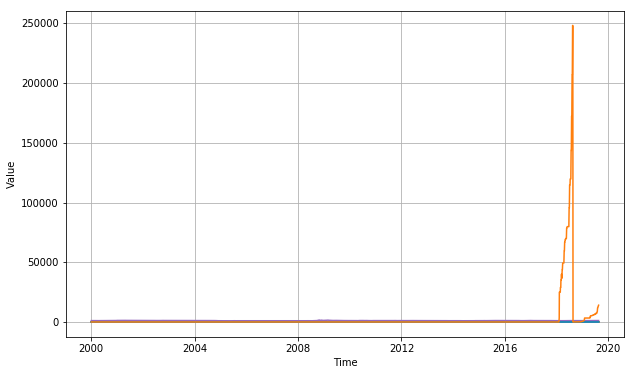

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# create a color palette
palette = plt.get_cmap('Set1')
 
def plot_series(time, series, label, format="-", start=0, end=None, color=palette(0)):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    #plt.legend()
    #plt.text(time[0], series[0], label, horizontalalignment='left', size='small', color='grey')

plt.figure(figsize=(10, 6))

# multiple line plot
num=0
for country in countries:
    num+=1
    #rdd = df_all.where(df_all['Country']==country)
    rdd = df_all['Date', country]
    print(country)
    values = rdd.collect()
    values = np.array([np.array([a,b]) for (a,b) in values])
    values = values.T    
    plot_series(values[0], values[1], country, color=palette(num))

plt.show()

In [48]:
import pandas as pd
df_pd = df_all.toPandas()
df_pd.count()
# df_pd = df_pd.sort_values(by=['Date'])
df_pd

,Date,Australia,Brazil,Canada,China,Denmark,EU,Hong_Kong,India,Japan,...,Singapore,South_Africa,South_Korea,Sri_Lanka,Sweden,Switzerland,Taiwan,Thailand,United_Kingdom,Venezuela
0,2000-01-04,0.6562,1.8405,1.4518,8.2799,7.2180,1.0309,7.7775,43.549999,103.089996,...,1.6535,6.0850,1122.500000,72.650002,8.3600,1.5565,30.600000,37.130001,1.6370,0.650300
1,2000-01-05,0.6550,1.8560,1.4518,8.2798,7.2080,1.0335,7.7780,43.549999,103.769997,...,1.6560,6.0700,1135.000000,72.949997,8.3530,1.5526,30.799999,37.099998,1.6415,0.651500
2,2000-01-06,0.6540,1.8400,1.4571,8.2797,7.2125,1.0324,7.7785,43.549999,105.190002,...,1.6655,6.0800,1146.500000,72.949997,8.3675,1.5540,31.750000,37.619999,1.6475,0.650300
3,2000-01-07,0.6548,1.8310,1.4505,8.2794,7.2285,1.0294,7.7783,43.549999,105.169998,...,1.6625,6.0570,1138.000000,73.150002,8.4150,1.5623,30.850000,37.299999,1.6384,0.650800
4,2000-01-10,0.6561,1.8190,1.4568,8.2794,7.2540,1.0252,7.7785,43.549999,105.279999,...,1.6618,6.0765,1133.500000,73.300003,8.4490,1.5704,30.830000,37.270000,1.6374,0.651800
5,2000-01-11,0.6575,1.8225,1.4570,8.2795,7.2140,1.0322,7.7785,43.599998,106.089996,...,1.6690,6.0900,1147.000000,73.349998,8.3970,1.5605,30.830000,37.610001,1.6480,0.652000
6,2000-01-12,0.6578,1.8350,1.4550,8.2796,7.2360,1.0281,7.7787,43.599998,105.760002,...,1.6690,6.0685,1144.500000,73.349998,8.4180,1.5660,30.799999,37.540001,1.6465,0.652600
7,2000-01-13,0.6687,1.8140,1.4495,8.2798,7.2520,1.0270,7.7788,43.549999,106.089996,...,1.6700,6.0570,1135.500000,73.349998,8.4170,1.5707,30.799999,37.490002,1.6482,0.653300
8,2000-01-14,0.6665,1.8050,1.4497,8.2797,7.3470,1.0128,7.7789,43.549999,105.860001,...,1.6752,6.0750,1125.000000,73.349998,8.4740,1.5945,30.830000,37.549999,1.6353,0.651300
9,2000-01-18,0.6640,1.7942,1.4502,8.2793,7.3560,1.0121,7.7790,43.599998,105.489998,...,1.6735,6.0890,1127.000000,72.849998,8.4680,1.5942,30.889999,37.400002,1.6380,0.653400


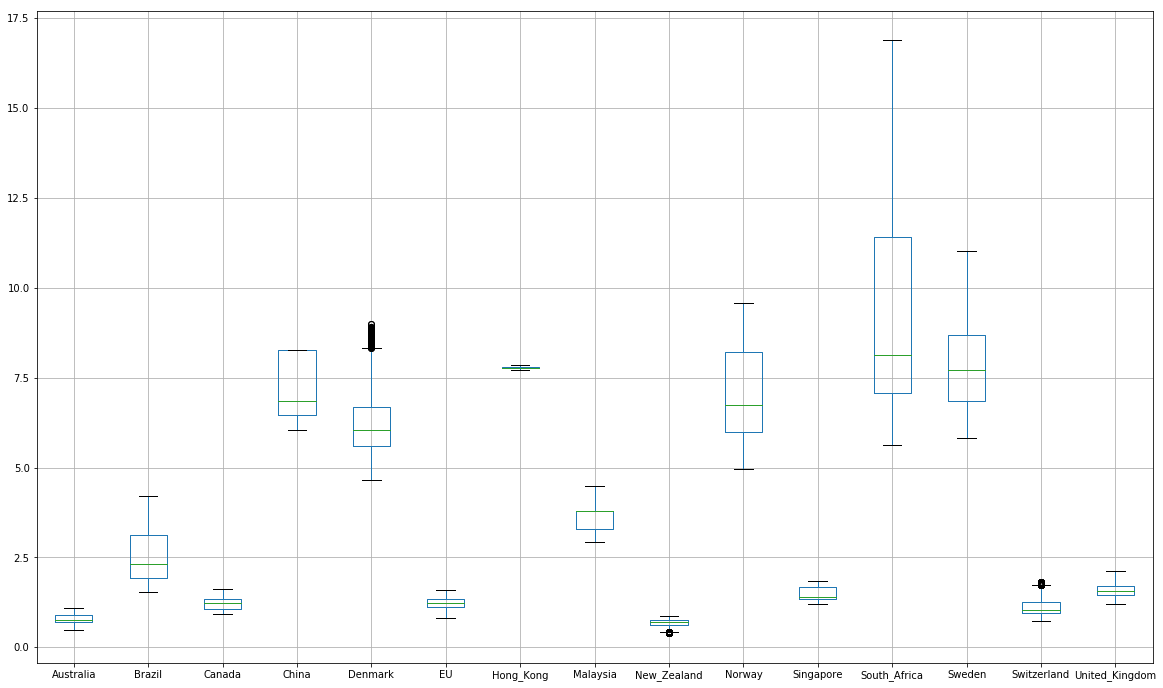

In [50]:
import seaborn as sns
# x = sns.swarmplot(x="Country", y="Exchange Rate", data=df_pd, color=".25")

# For visualizing the data, need to drop countries
# that had 'currency crises' during the time interval
# otherwise the scale is orders of magnitude off

df_plot = df_pd.drop('Venezuela', axis=1)
df_plot = df_plot.drop('South_Korea', axis=1)
df_plot = df_plot.drop('Sri_Lanka', axis=1)
df_plot = df_plot.drop('Japan', axis=1)
df_plot = df_plot.drop('India', axis=1)
df_plot = df_plot.drop('Thailand', axis=1)
df_plot = df_plot.drop('Taiwan', axis=1)

df_plot.boxplot(figsize=(20,12))

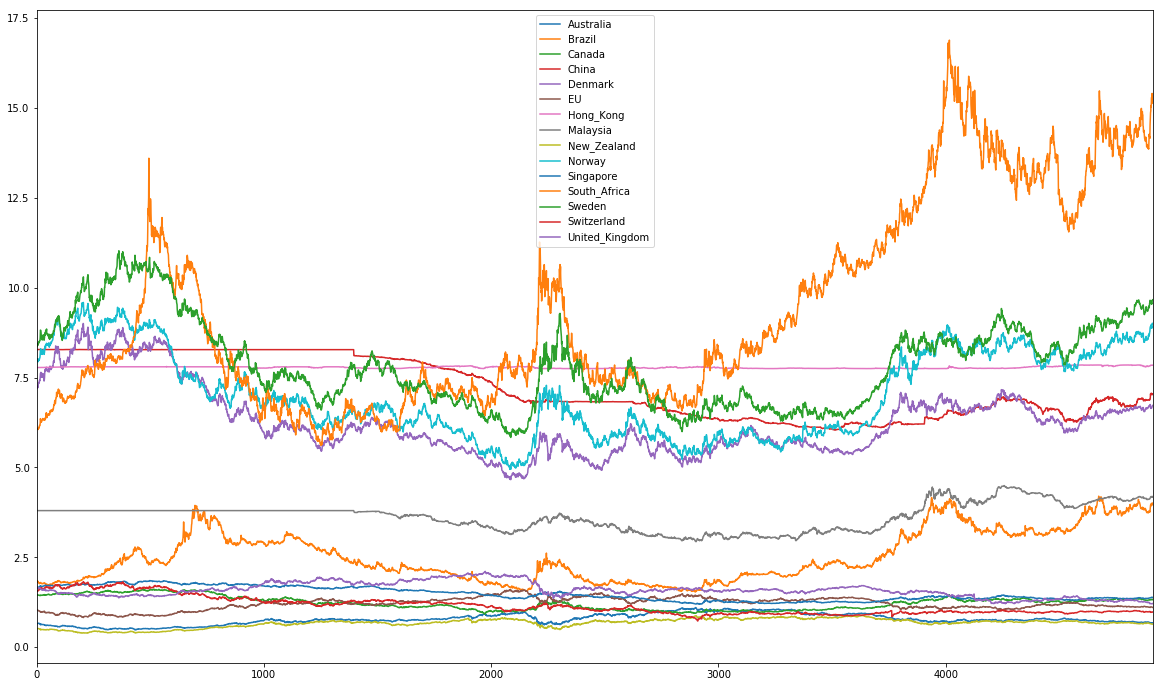

In [52]:
# Take a look at the time series to see if any of the exchanage rates
# seem to move together

df_plot.plot.line(figsize=(20,12))

In [29]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(values[1], order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 4919
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -47374.859
Method:                       css-mle   S.D. of innovations           3685.091
Date:                Tue, 27 Aug 2019   AIC                          94763.718
Time:                        22:38:50   BIC                          94809.224
Sample:                             1   HQIC                         94779.681
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8534     47.909      0.060      0.953     -91.047      96.754
ar.L1.D.y     -0.0002      0.014     -0.014      0.989      -0.028       0.028
ar.L2.D.y      0.0011      0.014      0.077      0.9

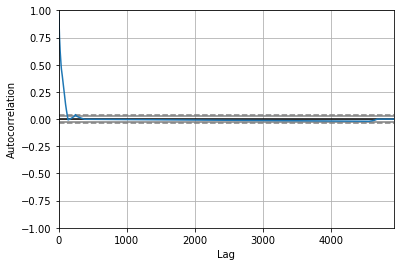

In [27]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(values[1])

In [ ]:
import zipfile

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('a2_m1.json.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('a2_m1.json', zipf)
zipf.close()